In [1]:
import skimage
from skimage import draw
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

from plot_helpers import show_image
from dataset_helpers import get_label

In [2]:
from dataset_helpers import max_normalise

In [3]:
npzfile = np.load('')
x = npzfile['x']
y = npzfile['y']

In [4]:
y_dmso = [get_label(file) for file in y]

In [5]:
x_dmso = np.reshape(x, (len(x), 192, 192))

# Evaluating overlap

In [6]:
def convert_to_binary(a):
    val = np.unique(a)[1]
    mask = np.copy(a)
    for idx, pixel in enumerate(a):
        if pixel == val:
            mask[idx] = 1
        else:
            mask[idx] = 0
    return mask.astype(np.uint8).reshape(192,192)

In [7]:
def get_mask(img):
    kmeans = KMeans(2).fit(img.reshape(np.prod(img.shape), 1))
    return convert_to_binary(kmeans.cluster_centers_[kmeans.labels_])

In [8]:
def iou(a,b):
    i = a & b
    u = a | b
    return (np.sum(i==1)/np.sum(u==1))*100

In [ ]:
idx = 0
overlaps = np.ndarray(shape=(len(x)//2, 2))
j = 0
while idx < 19600:
    if (idx % 500 == 0):
        print(idx, idx+100)
    if (idx % 100 == 0) and (idx % 200 != 0):
        idx += 100
    else:
        tcell = get_mask(max_normalise(x[idx]))
        dcell = get_mask(max_normalise(x[idx+100]))
        overlaps[j, :] = [iou(tcell, dcell), get_label(y[idx])]
        idx+=1
        j+=1 

In [156]:
unstimulated = overlaps[overlaps[:, 1] == 0, 0]
ova = overlaps[overlaps[:, 1] == 1, 0]
cona = overlaps[overlaps[:, 1] == 2, 0]

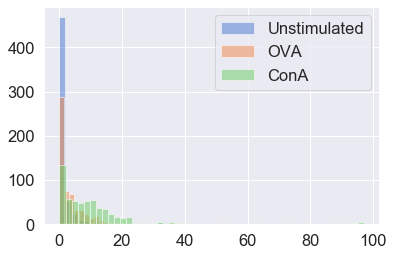

In [157]:
plt.hist(unstimulated[:600], bins=50, alpha=0.5, label="Unstimulated")
plt.hist(ova[:600], bins=50, alpha=0.5, label="OVA")
plt.hist(cona[:600], bins=50, alpha=0.5, label="ConA")
plt.legend()
plt.show()

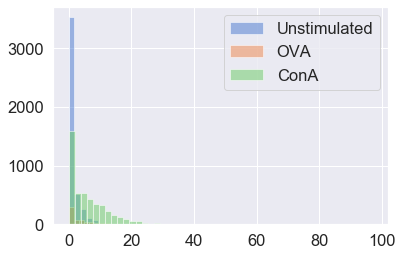

In [140]:
plt.hist(unstimulated, bins=50, alpha=0.5, label="Unstimulated")
plt.hist(ova, bins=50, alpha=0.5, label="OVA")
plt.hist(cona, bins=50, alpha=0.5, label="ConA")
plt.legend()
plt.show()

# Thresholding

In [24]:
def threshold(x):
    mean = np.median(x)
    mask = np.copy(x)
    mask = mask.ravel()
    for idx, pixel in enumerate(x.ravel()):
        if pixel > mean+x.std():
            mask[idx] = 1
        else:
            mask[idx] = 0
    return mask.reshape(192,192)

In [15]:
img = x[105]

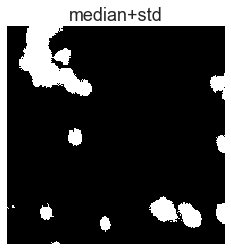

In [25]:
show_image(threshold(img), "median+std")

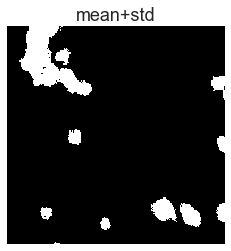

In [23]:
show_image(threshold(img), "mean+std")

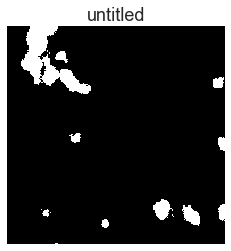

In [81]:
show_image(get_mask(img))

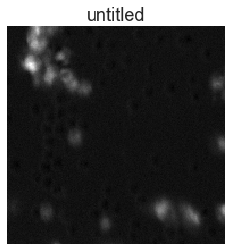

In [42]:
show_image(img)

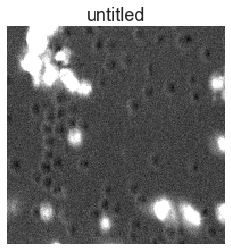

In [32]:
show_image(mean_clip(img))

In [ ]:
mean = img.mean()
new = np.copy(img)
for x, row in enumerate(img):
    for y, pixel in enumerate(row):
        if pixel < mean-126:
            pixel = mean-126
        elif pixel > mean+127:
            print(pixel)
            pixel = mean+127
        new[x,y] = pixel

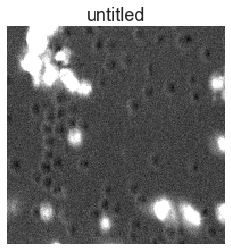

In [61]:
show_image(new)

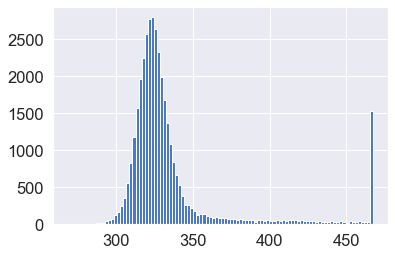

In [63]:
plt.hist(new.ravel(), bins=100)
plt.show()

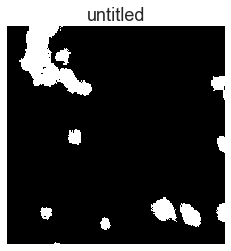

In [47]:
show_image(threshold(img))

## K-Means Colour Clustering

In [142]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [6]:
green_img = np.reshape(x[3], (192*192, 1))

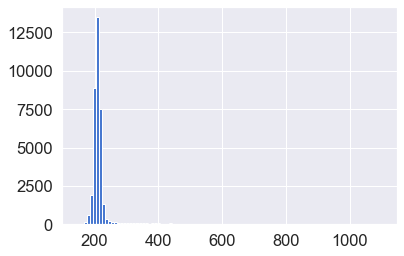

In [8]:
plt.hist(green_img.ravel(), bins=100)
plt.show()

In [226]:
K = 2
attempts=10
ret,label,center=cv2.kmeans(green_img,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [227]:
center = np.uint8(center)

In [228]:
res = center[label.flatten()]
green_result = res.reshape((192, 192))

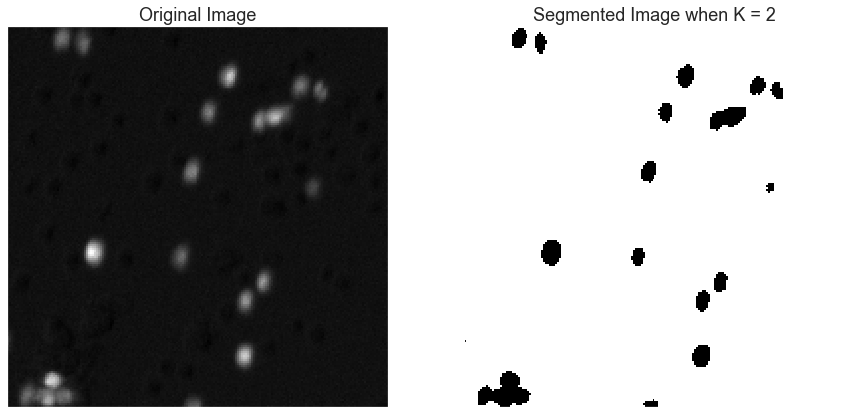

In [229]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(x[3], cmap="gray")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(green_result, cmap="gray")
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [230]:
red_img = np.reshape(x[103], (192*192, 1))

In [189]:
K = 2
attempts=10
ret,label,center=cv2.kmeans(red_img,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [190]:
center = np.uint8(center)

In [191]:
res = center[label.flatten()]
red_result = res.reshape((192, 192))

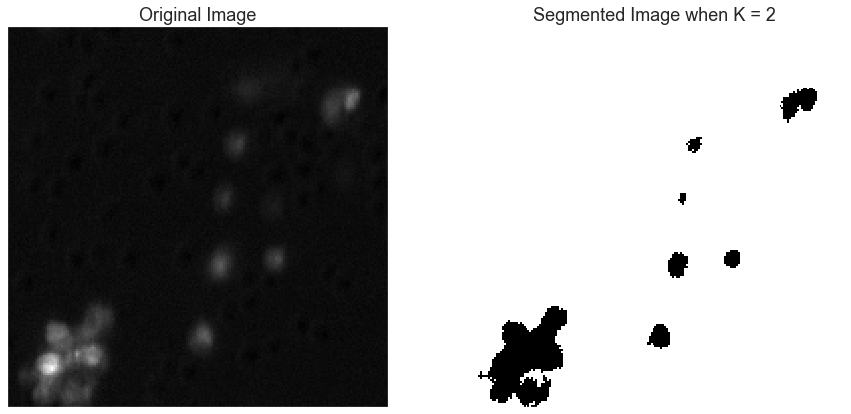

In [192]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(x[103], cmap="gray")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(red_result, cmap="gray")
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [234]:
kmeans = KMeans(K).fit(green_img)

In [239]:
res = kmeans.cluster_centers_[kmeans.labels_]
green_result_2 = res.reshape((192, 192))

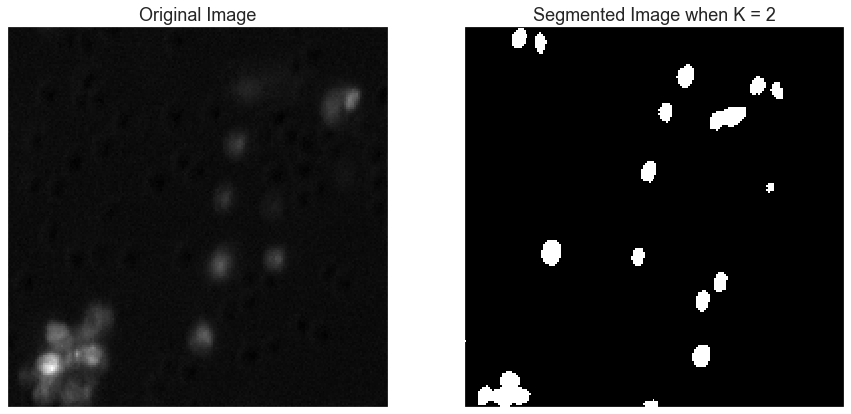

In [240]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(x[103], cmap="gray")
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(green_result_2, cmap="gray")
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [274]:
green = get_mask(x[3])

In [275]:
red = get_mask(x[103])

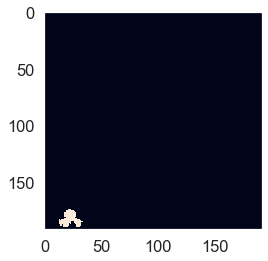

In [75]:
plt.imshow(np.reshape(green & red, (192, 192)))
plt.grid(False)

In [96]:
img = np.ndarray(shape=(192, 192, 3))
img[:, :, 0] = red.reshape(192, 192)
img[:, :, 1] = green.reshape(192, 192)

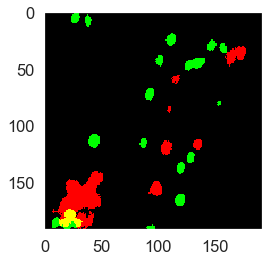

In [98]:
plt.imshow(img)
plt.grid(False)

## Intersection over union

In [109]:
# using skimage.draw.circle
c1 = np.zeros((64,64))
# cx, cy set position; radius sets... the radius.
r,c = skimage.draw.circle(c=c1.shape[1]/3, r=c1.shape[0]/2, radius=10)
c1[r,c]=1

In [110]:
# using skimage.draw.circle
c2 = np.zeros((64,64))
# cx, cy set position; radius sets... the radius.
r,c = skimage.draw.circle(c=c2.shape[1]/2, r=c2.shape[0]/2, radius=11)
c2[r,c]=1

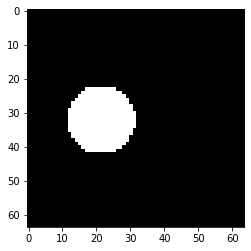

In [80]:
plt.imshow(c1, cmap="gray")

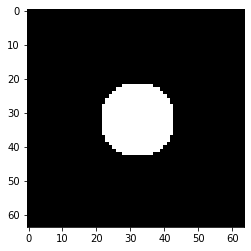

In [81]:
plt.imshow(c2, cmap="gray")

In [74]:
t = c1.astype("bool") & c2.astype("bool")

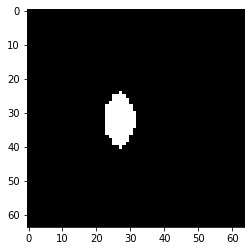

In [78]:
plt.imshow(t.astype("uint8"), cmap="gray")

In [112]:
iou(c1.astype("bool"), c2.astype("bool"))

23.508137432188065